### Etiologic Classification of Macular Edema Using Convolutional Neural Networks & Random Forest in Optical Coherence Tomography Scans dataset

```
    This Project employs CNN Architecture for Feature Extraction of Medical Scans. 
    It consists of an encoder blocks that downsample the feature maps, and traditional machine learning algorithm that predicts based on features.


    For images multi-classification between all diseases dataset folder contains all images resized into 256 * 256, and in both divided among training, 
    test and augmented sets for:

    - Control
    - DME
    - AMD
    - RVO
```

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install tensorflow==2.8 matplotlib opencv-python scikit-learn segmentation_models protobuf==3.20.* prettytable natsort seaborn

Constants

In [2]:
import sys
import logging
logging.getLogger('tensorflow').disabled = True

SIZE = 256, 256
NUM_CLASSES = 4
PRESENTATION = True

DISEASES = {
    "acontrol": "Normal",
    "dme":"DME",
    "amd":"AMD",
    "retinal_vein_occlusion":"RVO"
}

COLAB = 'google.colab' in sys.modules
if COLAB:
    root = '/content/drive/MyDrive/Colab Notebooks'
else:
    root = '.'

Image Augmentation

In [3]:
import shutil
from keras.preprocessing.image import ImageDataGenerator
from skimage import io

datagen = ImageDataGenerator(shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='reflect')

import numpy as np
from pathlib import Path
from glob import glob
from natsort import natsorted
import cv2
import os
image_directories = f'{root}/dataset/training/**'
os.makedirs(f'{root}/dataset/augmented-display', exist_ok=True)

for image_directory in glob(image_directories):
    disease = Path(image_directory).name
    shutil.rmtree(f'{root}/dataset/augmented-display/{disease}', ignore_errors=True)
    os.makedirs(f'{root}/dataset/augmented-display/{disease}')

for image_directory in glob(image_directories):
    img_dir = Path(image_directory)
    disease = img_dir.name
    image_glob = glob(str(img_dir.joinpath('*')))
    print(img_dir.joinpath('*'))
    SIZE = 256, 256
    dataset = []

    for image_name in natsorted(image_glob):
        image = cv2.imread(image_name, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, SIZE)
        dataset.append(np.array(image))

    x = np.array(dataset)
    
    i = 0
    limit = 300 - len(image_glob)
    print(f"{limit} images required to make 300 total images per class")
    while i < limit:
        next(datagen.flow(x, batch_size=1, save_to_dir=f'{root}/dataset/augmented-display/{disease}', save_prefix='aug', save_format='png'))
        i += 1


dataset\training\acontrol\*
8 images required to make 300 total images per class
dataset\training\amd\*
0 images required to make 300 total images per class
dataset\training\dme\*
176 images required to make 300 total images per class
dataset\training\retinal_vein_occlusion\*
149 images required to make 300 total images per class


Helper Functions

In [4]:
import cv2
import numpy as np
from glob import glob
import tensorflow as tf
from pathlib import Path
from natsort import natsorted
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def pre(path: str, size):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return cv2.resize(img, size)

def classification_array(path: str):
    images = []
    labels = []
    for directory_path in glob(path):
        dir_path = Path(directory_path)
        label = dir_path.name
        for img_path in natsorted(glob(str(dir_path.joinpath("*.png")))):
            images.append(pre(img_path, SIZE))
            labels.append(label)
    return np.array(images), np.array(labels)

def grad_cam(model, layer_name: str, img_array):
    img_tensor = tf.convert_to_tensor(img_array)
    img_tensor = tf.expand_dims(img_tensor, axis=0)

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        loss = predictions[:, np.argmax(predictions[0])]
    
    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(conv_outputs, pooled_grads), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    return heatmap

def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def superimpose(img_bgr, cam, thresh, emphasize=False):
    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        
    heatmap = heatmap.astype('float32')
    img_bgr = img_bgr.astype('float32') * 255.0
    superimposed_img_rgb = cv2.addWeighted(heatmap, 0.4, img_bgr, 0.6, 0)
    superimposed_img_rgb = cv2.cvtColor(superimposed_img_rgb, cv2.COLOR_BGR2RGB)

    return superimposed_img_rgb / 255.0

def evaluate_model(labels, predictions, classes):
    return accuracy_score(labels, predictions), \
            precision_score(labels, predictions, average='macro'), \
            recall_score(labels, predictions, average='macro'), \
            f1_score(labels, predictions, average='macro'), \
            classification_report(labels, predictions, target_names=classes, output_dict=True)


Feature Extractors

In [5]:
import tensorflow as tf


def sequential_feature(input_shape, activation = 'relu'):
    
    feature_extractor = tf.keras.Sequential(name="Seq")
        
    feature_extractor.add(tf.keras.layers.Conv2D(16, 3, activation=activation, padding='same', input_shape=input_shape))
    feature_extractor.add(tf.keras.layers.BatchNormalization())

    feature_extractor.add(tf.keras.layers.Conv2D(16, 3, activation=activation, padding='same'))
    feature_extractor.add(tf.keras.layers.BatchNormalization())
    feature_extractor.add(tf.keras.layers.MaxPooling2D())

    feature_extractor.add(tf.keras.layers.Conv2D(32, 3, activation=activation, padding='same'))
    feature_extractor.add(tf.keras.layers.BatchNormalization())

    feature_extractor.add(tf.keras.layers.Conv2D(32, 3, activation=activation, padding='same'))
    feature_extractor.add(tf.keras.layers.BatchNormalization())
    feature_extractor.add(tf.keras.layers.MaxPooling2D())

    feature_extractor.add(tf.keras.layers.Conv2D(64, 3, activation=activation, padding='same'))
    feature_extractor.add(tf.keras.layers.BatchNormalization())

    feature_extractor.add(tf.keras.layers.Conv2D(64, 3, activation=activation, padding='same'))
    feature_extractor.add(tf.keras.layers.BatchNormalization())
    feature_extractor.add(tf.keras.layers.MaxPooling2D())

    feature_extractor.add(tf.keras.layers.Conv2D(128, 3, activation=activation, padding='same'))
    feature_extractor.add(tf.keras.layers.BatchNormalization())

    feature_extractor.add(tf.keras.layers.Conv2D(128, 3, name='grad_cam', activation=activation, padding='same'))
    feature_extractor.add(tf.keras.layers.BatchNormalization())
    feature_extractor.add(tf.keras.layers.MaxPooling2D())
    
    
    feature_extractor.add(tf.keras.layers.Flatten())
    
    
    return feature_extractor

def separable_sequential_feature(input_shape, activation='relu'):
    feature_extractor = tf.keras.Sequential(name="Mod_Seq")

    feature_extractor.add(tf.keras.layers.Conv2D(8, 3, activation=activation, padding='same', input_shape=input_shape))

    feature_extractor.add(tf.keras.layers.Conv2D(8, 3, activation=activation, padding='same'))

    feature_extractor.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))

    feature_extractor.add(tf.keras.layers.SeparableConv2D(16, 3, activation=activation, padding='same'))
    feature_extractor.add(tf.keras.layers.SeparableConv2D(16, 3, activation=activation, padding='same'))
    feature_extractor.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))

    feature_extractor.add(tf.keras.layers.SeparableConv2D(32, 3, activation=activation, padding='same'))
    feature_extractor.add(tf.keras.layers.SeparableConv2D(32, 3, activation=activation, padding='same'))
    feature_extractor.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))

    feature_extractor.add(tf.keras.layers.SeparableConv2D(64, 3, activation=activation, padding='same'))
    feature_extractor.add(tf.keras.layers.SeparableConv2D(64, 3, activation=activation, padding='same'))
    feature_extractor.add(tf.keras.layers.MaxPooling2D())

    feature_extractor.add(tf.keras.layers.Conv2D(128, 3, activation=activation, padding='same'))
    feature_extractor.add(tf.keras.layers.Conv2D(128, 3, name='grad_cam', activation=activation, padding='same'))
    feature_extractor.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))

    feature_extractor.add(tf.keras.layers.Flatten())

    return feature_extractor

from skimage.feature import graycomatrix, graycoprops

def glcm_features(image):
    if len(image.shape) > 2:
        image = np.mean(image, axis=2)

    image = ((image - np.min(image)) / (np.max(image) - np.min(image))) * 255

    image = image.astype(np.uint8)

    distances = [2]
    angles = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]
    glcm = graycomatrix(image, distances, angles, levels=256, symmetric=False, normed=True)

    properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    features = np.hstack([graycoprops(glcm, prop).ravel() for prop in properties])

    return features

Load Images

In [6]:
import numpy as np

raw_images, raw_labels = classification_array(f"{root}/dataset/training/*")
aug_images, aug_labels = classification_array(f"{root}/dataset/augmented/*")

train_images, train_labels = np.concatenate((raw_images, aug_images), axis=0), np.concatenate((raw_labels, aug_labels), axis=0)
test_images, test_labels = classification_array(f"{root}/dataset/test/*")

print(f"{raw_images.shape = } {raw_labels.shape = }")
print(f"{aug_images.shape = } {aug_labels.shape = }")
print(f"{train_images.shape = } {train_labels.shape = }")


raw_images.shape = (867, 256, 256, 3) raw_labels.shape = (867,)
aug_images.shape = (333, 256, 256, 3) aug_labels.shape = (333,)
train_images.shape = (1200, 256, 256, 3) train_labels.shape = (1200,)


Compute Class Weights

In [7]:
unique_labels, counts = np.unique(raw_labels, return_counts=True)
total_samples = len(raw_labels)
class_weights = total_samples / (len(unique_labels) * counts)
class_weights = class_weights / np.max(class_weights)
print(class_weights)

[0.42465753 0.41333333 1.         0.82119205]


Preprocess Input Labels

In [8]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(test_labels)
le.fit(train_labels)
classes = le.classes_

test_labels_encoded = le.transform(test_labels)
train_labels_encoded = le.transform(train_labels)

Normalise Image Array

In [9]:
x_train, x_test = train_images / 255.0, test_images / 255.0
y_train, y_test = train_labels_encoded, test_labels_encoded

Extract Feature from Image Array

In [10]:
input_shape = x_train.shape[1:]

activation = 'relu'

print("Extracting Features for CRF")

feature_extractor = sequential_feature(input_shape, activation)
sep_feature_extractor = separable_sequential_feature(input_shape, 'relu')


for l in feature_extractor.layers:
    l.trainable = False
    
for l in sep_feature_extractor.layers:
    l.trainable = False
    
# feature_extractor.summary()
# mod_feature_extractor.summary()

 
print("Parameters")
print("Normal: ", feature_extractor.count_params())

print("Modified: ", sep_feature_extractor.count_params())

Extracting Features for CRF
Parameters
Normal:  295440
Modified:  232048


Random Forest + CNN

In [11]:
from sklearn.ensemble import RandomForestClassifier
from multiprocessing import cpu_count

cpu = min(16, cpu_count())

print("Initializing Random Forest")
print(f"Using {cpu} CPUs")

rf_cnn = RandomForestClassifier(
    n_estimators=500,
    bootstrap=True,
    oob_score=True,
    n_jobs=cpu,
    class_weight=dict(enumerate(class_weights)),
    random_state=42
)

print("Fitting data with RF")

x_cnn = feature_extractor.predict(x_train)

rf_cnn.fit(x_cnn, y_train)

print("Predicting Test data with RF")

x_test_cnn = feature_extractor.predict(x_test)
prediction_cnn = rf_cnn.predict(x_test_cnn)
prediction_cnn = le.inverse_transform(prediction_cnn)

Initializing Random Forest
Using 16 CPUs
Fitting data with RF
Predicting Test data with RF


RF-CNN Result

In [12]:
from prettytable import PrettyTable


comparison = PrettyTable()

comparison.field_names = ["Metric", "Percentage"]

accuracy_cnn, precision_cnn, recall_cnn, f1_cnn, report_cnn = evaluate_model(test_labels, prediction_cnn, classes)
comparison.add_row(["OOB", round((rf_cnn.oob_score_) * 100, 2)])
comparison.add_row(["Accuracy", round((accuracy_cnn * 100), 2)])
comparison.add_row(["Precision",round(precision_cnn * 100, 2)])
comparison.add_row(["Recall", round(recall_cnn * 100, 2)])
comparison.add_row(["F1 Score", round(f1_cnn * 100, 2)])

print(comparison)

report_table = PrettyTable()
avg_table = PrettyTable()
acc_table = PrettyTable()

report_table.field_names = ["Disease", "Precision", "Recall", "F1 Score", "Support"]
avg_table.field_names = ["Average", "Precision", "Recall", "F1 Score", "Support"]
acc_table.field_names = ["Metric", "Percentage", "Support"]

print("\nClassification Report")

for disease, metric in list(report_cnn.items())[:4]:
    report_table.add_row([DISEASES[disease], *list(map(lambda x: round(x * 100 if isinstance(x, float) else x, 2), metric.values()))])

for avg, metric in list(report_cnn.items())[5:]:
    avg_table.add_row([avg, *list(map(lambda x: round(x * 100 if isinstance(x, float) else x, 2), metric.values()))])

avg, metric = list(report_cnn.items())[4]
acc_table.add_row([avg, f"{metric * 100:.1f}", 120])

print(acc_table)
print(avg_table)
print(report_table)


+-----------+------------+
|   Metric  | Percentage |
+-----------+------------+
|    OOB    |   78.58    |
|  Accuracy |   83.33    |
| Precision |    86.9    |
|   Recall  |   83.33    |
|  F1 Score |   81.13    |
+-----------+------------+

Classification Report
+----------+------------+---------+
|  Metric  | Percentage | Support |
+----------+------------+---------+
| accuracy |    83.3    |   120   |
+----------+------------+---------+
+--------------+-----------+--------+----------+---------+
|   Average    | Precision | Recall | F1 Score | Support |
+--------------+-----------+--------+----------+---------+
|  macro avg   |    86.9   | 83.33  |  81.13   |   120   |
| weighted avg |    86.9   | 83.33  |  81.13   |   120   |
+--------------+-----------+--------+----------+---------+
+---------+-----------+--------+----------+---------+
| Disease | Precision | Recall | F1 Score | Support |
+---------+-----------+--------+----------+---------+
|  Normal |   93.33   | 93.33  |  93.3

Random Forest + Separable CNN

In [13]:
from sklearn.ensemble import RandomForestClassifier
from multiprocessing import cpu_count

cpu = min(16, cpu_count())

print("Initializing Mod Random Forest")
print(f"Using {cpu} CPUs")

rf_cnn_glcm = RandomForestClassifier(
    n_estimators=500,
    bootstrap=True,
    oob_score=True,
    n_jobs=cpu,
    class_weight=dict(enumerate(class_weights)),
    random_state=42
)

print("Fitting data with Mod RF")
x_sep_cnn = sep_feature_extractor.predict(x_train)

# Compute GLCM features
x_glcm = np.array([glcm_features(image) for image in x_train])
x_cnn_glcm = np.hstack([x_sep_cnn, x_glcm])

rf_cnn_glcm.fit(x_cnn_glcm, y_train)

print("Predicting Test data with Mod RF")

x_test_sep_cnn = sep_feature_extractor.predict(x_test)
x_test_glcm = np.array([glcm_features(image) for image in x_test])

x_test_cnn_glcm = np.hstack([x_test_sep_cnn, x_test_glcm])

prediction_cnn_glcm = rf_cnn_glcm.predict(x_test_cnn_glcm)
prediction_cnn_glcm = le.inverse_transform(prediction_cnn_glcm)

Initializing Mod Random Forest
Using 16 CPUs
Fitting data with Mod RF
Predicting Test data with Mod RF


Save Models

In [14]:
# import joblib

# joblib.dump(rf_cnn_glcm, f"{root}/trained_model/random_forest_cnn_glcm_display.joblib")
# tf.keras.models.save_model(sep_feature_extractor, f'{root}/trained_model/separable_feature_extractor_display')

RF-SCNN-GLCM Result

In [15]:
import joblib
from prettytable import PrettyTable

comparison = PrettyTable()

comparison.field_names = ["Metric", "Percentage"]

if PRESENTATION:
    sep_feature_extractor = tf.keras.models.load_model(f'{root}/trained_model/separable_feature_extractor', compile=False)
    rf_cnn_glcm = joblib.load(f"{root}/trained_model/random_forest_cnn_glcm.joblib")
    x_sep_cnn = sep_feature_extractor.predict(x_train)

    x_glcm = np.array([glcm_features(image) for image in x_train])
    x_cnn_glcm = np.hstack([x_sep_cnn, x_glcm])

    rf_cnn_glcm.fit(x_cnn_glcm, y_train)

    x_test_sep_cnn = sep_feature_extractor.predict(x_test)
    x_test_glcm = np.array([glcm_features(image) for image in x_test])

    x_test_cnn_glcm = np.hstack([x_test_sep_cnn, x_test_glcm])

    prediction_cnn_glcm = rf_cnn_glcm.predict(x_test_cnn_glcm)
    prediction_cnn_glcm = le.inverse_transform(prediction_cnn_glcm)


accuracy_cnn_glcm, precision_cnn_glcm, recall_cnn_glcm, f1_cnn_glcm, report_cnn_glcm = evaluate_model(test_labels, prediction_cnn_glcm, classes)
comparison.add_row(["OOB", round((rf_cnn_glcm.oob_score_) * 100, 2)])
comparison.add_row(["Accuracy", round((accuracy_cnn_glcm * 100), 2)])
comparison.add_row(["Precision",round(precision_cnn_glcm * 100, 2)])
comparison.add_row(["Recall", round(recall_cnn_glcm * 100, 2)])
comparison.add_row(["F1 Score", round(f1_cnn_glcm * 100, 2)])

print(comparison)

report_table = PrettyTable()
avg_table = PrettyTable()
acc_table = PrettyTable()

report_table.field_names = ["Disease", "Precision", "Recall", "F1 Score", "Support"]
avg_table.field_names = ["Average", "Precision", "Recall", "F1 Score", "Support"]
acc_table.field_names = ["Metric", "Percentage", "Support"]

print("\nClassification Report")

for disease, metric in list(report_cnn.items())[:4]:
    report_table.add_row([DISEASES[disease], *list(map(lambda x: round(x * 100 if isinstance(x, float) else x, 2), metric.values()))])

for avg, metric in list(report_cnn.items())[5:]:
    avg_table.add_row([avg, *list(map(lambda x: round(x * 100 if isinstance(x, float) else x, 2), metric.values()))])

avg, metric = list(report_cnn.items())[4]
acc_table.add_row([avg, f"{metric * 100:.1f}", 120])

print(acc_table)
print(avg_table)
print(report_table)


+-----------+------------+
|   Metric  | Percentage |
+-----------+------------+
|    OOB    |   83.67    |
|  Accuracy |   86.67    |
| Precision |   88.78    |
|   Recall  |   86.67    |
|  F1 Score |   85.95    |
+-----------+------------+

Classification Report
+----------+------------+---------+
|  Metric  | Percentage | Support |
+----------+------------+---------+
| accuracy |    83.3    |   120   |
+----------+------------+---------+
+--------------+-----------+--------+----------+---------+
|   Average    | Precision | Recall | F1 Score | Support |
+--------------+-----------+--------+----------+---------+
|  macro avg   |    86.9   | 83.33  |  81.13   |   120   |
| weighted avg |    86.9   | 83.33  |  81.13   |   120   |
+--------------+-----------+--------+----------+---------+
+---------+-----------+--------+----------+---------+
| Disease | Precision | Recall | F1 Score | Support |
+---------+-----------+--------+----------+---------+
|  Normal |   93.33   | 93.33  |  93.3

RF-CNN vs RF-Sep CNN

(120, 4)
(120, 4)
(120, 4)
(120, 4)


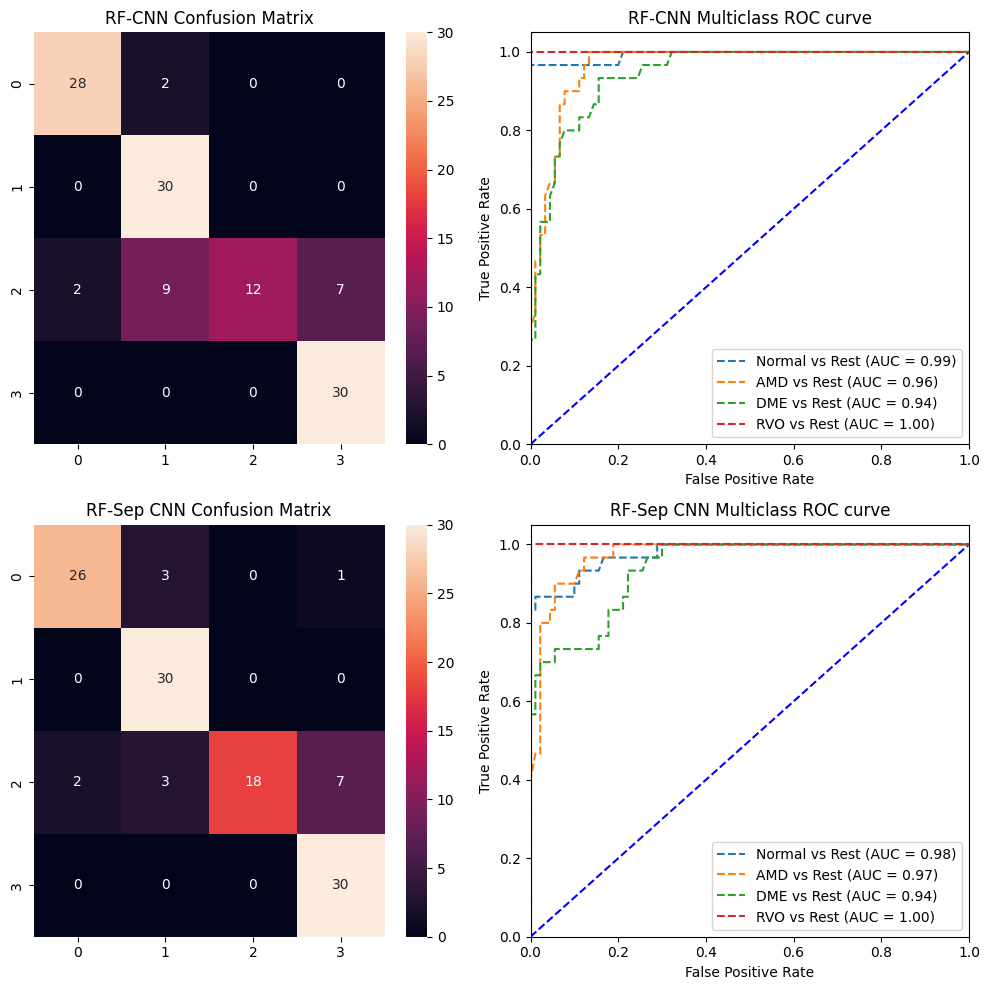

In [23]:
import seaborn as sns
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

comparison = PrettyTable()

comparison.field_names = ["Metric", "RF-CNN", "RF-Sep CNN"]

comparison.add_row(["OOB", round((rf_cnn.oob_score_) * 100, 2), round((rf_cnn_glcm.oob_score_) * 100, 2)])
comparison.add_row(["Accuracy", round((accuracy_cnn * 100), 2), round((accuracy_cnn_glcm * 100), 2)])
comparison.add_row(["Precision",round(precision_cnn * 100, 2), round(precision_cnn_glcm * 100, 2)])
comparison.add_row(["Recall", round(recall_cnn * 100, 2), round(recall_cnn_glcm * 100, 2)])
comparison.add_row(["F1 Score", round(f1_cnn * 100, 2), round(f1_cnn_glcm * 100, 2)])

# print(comparison)

cm_cnn = confusion_matrix(test_labels, prediction_cnn)
cm_cnn_glcm = confusion_matrix(test_labels, prediction_cnn_glcm)

y_prob_cnn = rf_cnn.predict_proba(x_test_cnn)
y_prob_cnn_glcm = rf_cnn_glcm.predict_proba(x_test_cnn_glcm)
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

fpr_cnn = {}
tpr_cnn = {}
thresh_cnn = {}
roc_auc_cnn = {}

fpr_cnn_glcm = {}
tpr_cnn_glcm = {}
thresh_cnn_glcm = {}
roc_auc_cnn_glcm = {}

n_class = classes.shape[0]

for idx in range(n_class):
    print(y_prob_cnn.shape)
    fpr_cnn[idx], tpr_cnn[idx], thresh_cnn[idx] = roc_curve(y_test_binarized[:, idx], y_prob_cnn[:, idx])
    fpr_cnn_glcm[idx], tpr_cnn_glcm[idx], thresh_cnn_glcm[idx] = roc_curve(y_test_binarized[:, idx], y_prob_cnn_glcm[:, idx])
    
    roc_auc_cnn[idx] = auc(fpr_cnn[idx], tpr_cnn[idx])
    roc_auc_cnn_glcm[idx] = auc(fpr_cnn_glcm[idx], tpr_cnn_glcm[idx])

# Subplots
fig, axs = pyplot.subplots(2, 2, figsize=(10, 10))

axs = axs.flatten()
# Confusion Matrix subplot
axs[0].set_title('RF-CNN Confusion Matrix')
axs[2].set_title('RF-Sep CNN Confusion Matrix')
sns.heatmap(cm_cnn, annot=True, ax=axs[0])
sns.heatmap(cm_cnn_glcm, annot=True, ax=axs[2])

# ROC Curve subplot
axs[1].set_title('RF-CNN Multiclass ROC curve')
axs[3].set_title('RF-Sep CNN Multiclass ROC curve')

axs[1].plot([0, 1], [0, 1], 'b--')
axs[1].set_xlim([0, 1])
axs[1].set_ylim([0, 1.05])
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')

axs[3].plot([0, 1], [0, 1], 'b--')
axs[3].set_xlim([0, 1])
axs[3].set_ylim([0, 1.05])
axs[3].set_xlabel('False Positive Rate')
axs[3].set_ylabel('True Positive Rate')

for idx in range(n_class):
    axs[1].plot(fpr_cnn[idx], tpr_cnn[idx], linestyle='--', label=f'{DISEASES[classes[idx]]} vs Rest (AUC = {roc_auc_cnn[idx]:0.2f})')
    axs[3].plot(fpr_cnn_glcm[idx], tpr_cnn_glcm[idx], linestyle='--', label=f'{DISEASES[classes[idx]]} vs Rest (AUC = {roc_auc_cnn_glcm[idx]:0.2f})')

axs[1].legend(loc='lower right')
axs[3].legend(loc='lower right')

pyplot.tight_layout()
pyplot.show()


Grad Cam Results

(256, 256, 3)
Grad Cam Comparison


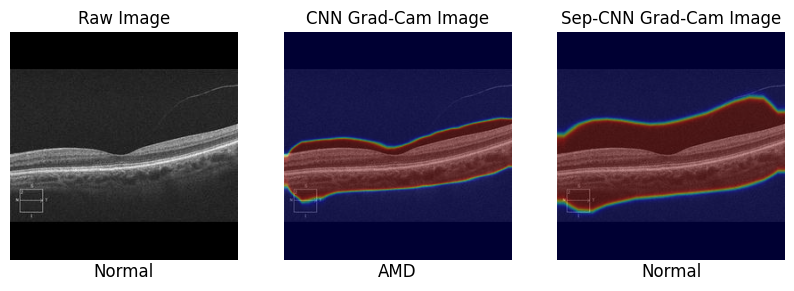

In [17]:
import random
from matplotlib import pyplot


test_img_idx = 20 #random.randint(0, len(x_test) - 1)
test_img = x_test[test_img_idx]

print(test_img.shape)
heatmap_cnn = grad_cam(feature_extractor, 'grad_cam', test_img)
heatmap_cnn = np.expand_dims(heatmap_cnn, axis=-1)
heatmap_cnn = tf.image.resize(heatmap_cnn, input_shape[:2]).numpy()
heatmap_cnn = np.squeeze(heatmap_cnn, axis=-1)

heatmap_scnn = grad_cam(sep_feature_extractor, 'grad_cam', test_img)
heatmap_scnn = np.expand_dims(heatmap_scnn, axis=-1)
heatmap_scnn = tf.image.resize(heatmap_scnn, input_shape[:2]).numpy()
heatmap_scnn = np.squeeze(heatmap_scnn, axis=-1)

grad_cam_cnn = superimpose(test_img, heatmap_cnn, 0.5, emphasize=True)
grad_cam_scnn = superimpose(test_img, heatmap_scnn, 0.5, emphasize=True)

fig, ax = pyplot.subplots(1, 3, figsize=(10, 5))

ax[0].imshow(test_img)
ax[0].title.set_text("Raw Image")
ax[0].axis('off')

# Overlay the heatmap on the original image with reduced opacity in the second subplot
ax[1].imshow(grad_cam_cnn)
ax[1].title.set_text("CNN Grad-Cam Image")
ax[1].axis('off')

ax[2].imshow(grad_cam_scnn)
ax[2].title.set_text("Sep-CNN Grad-Cam Image")
ax[2].axis('off')

input_img = np.expand_dims(test_img, axis=0)
input_img_cnn = feature_extractor.predict(input_img)

input_img_sep_cnn = sep_feature_extractor.predict(input_img)
input_img_glcm = np.array([glcm_features(image) for image in input_img])

input_img_cnn_glcm = np.hstack([input_img_sep_cnn, input_img_glcm])


input_prediction_cnn = rf_cnn.predict(input_img_cnn)[0] 
input_prediction_cnn = le.inverse_transform([input_prediction_cnn])
input_prediction_cnn_glcm = rf_cnn_glcm.predict(x_test_cnn_glcm)[0]
input_prediction_cnn_glcm = le.inverse_transform([input_prediction_cnn_glcm])

ax[0].text(0.5, -0.075, f"{DISEASES[test_labels[test_img_idx]]}", size=12, ha="center", transform=ax[0].transAxes)
ax[1].text(0.5, -0.075, f"{DISEASES[input_prediction_cnn[0]]}", size=12, ha="center", transform=ax[1].transAxes)
ax[2].text(0.5, -0.075, f"{DISEASES[input_prediction_cnn_glcm[0]]}", size=12, ha="center", transform=ax[2].transAxes)

print("Grad Cam Comparison")